<a href="https://colab.research.google.com/github/thanhdtnguyen/Deep-Learning-with-Keras-Tensorflow/blob/master/convnet_dog_cat_with_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os 
import zipfile
import random
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from shutil import copyfile

In [2]:
# download and extract zip file

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = "/tmp/cats-and-dogs.zip"
zip_ref = zipfile.ZipFile(local_zip, "r")
zip_ref.extractall("/tmp")
zip_ref.close()

--2020-08-23 04:53:21--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 184.26.80.188, 2600:1409:a:283::e59, 2600:1409:a:296::e59
Connecting to download.microsoft.com (download.microsoft.com)|184.26.80.188|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   180MB/s    in 4.5s    

2020-08-23 04:53:26 (176 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [3]:
print(len(os.listdir("/tmp/PetImages/Cat")))
print(len(os.listdir("/tmp/PetImages/Dog")))

12501
12501


In [4]:
# create directories 

try:
  base_dir = "/tmp/cats-v-dogs"
  os.mkdir(base_dir)

  training_dir = os.path.join(base_dir, "training")
  os.mkdir(training_dir)

  testing_dir = os.path.join(base_dir, "testing")
  os.mkdir(testing_dir)

  training_cats_dir = os.path.join(training_dir, "cats")
  os.mkdir(training_cats_dir)
  testing_cats_dir = os.path.join(testing_dir, "cats")
  os.mkdir(testing_cats_dir)

  training_dogs_dir = os.path.join(training_dir, "dogs")
  os.mkdir(training_dogs_dir)
  testing_dogs_dir = os.path.join(testing_dir, "dogs")
  os.mkdir(testing_dogs_dir)
except OSError:
  pass

In [5]:
# preprocess data

def split_data(source, training, testing, split_size):

  image_list = []

  file_names = os.listdir(source)

  for file_data in file_names:
      data = source + file_data
      if (os.path.getsize(data) > 0):
          image_list.append(file_data)
      else:
          print(file_data + " is invalid, so ignoring.")
    
  shuffled_set = random.sample(image_list, len(image_list))
  
  for index, file in enumerate(shuffled_set):
    if index < int(split_size * len(image_list)):
      ftrain = copyfile(os.path.join(source, file), os.path.join(training, file))
    else:
      ftest = copyfile(os.path.join(source, file), os.path.join(testing, file))


cat_source_dir = "/tmp/PetImages/Cat/"
dog_source_dir = "/tmp/PetImages/Dog/"

split_size = .9
split_data(cat_source_dir, training_cats_dir, testing_cats_dir, split_size)
split_data(dog_source_dir, training_dogs_dir, testing_dogs_dir, split_size)

666.jpg is invalid, so ignoring.
11702.jpg is invalid, so ignoring.


In [6]:
print(len(os.listdir(training_cats_dir)))
print(len(os.listdir(training_dogs_dir)))
print(len(os.listdir(testing_cats_dir)))
print(len(os.listdir(testing_dogs_dir)))

11250
11250
1250
1250


In [7]:
# callbacks

class myCallback(keras.callbacks.Callback):

  def on_epoch_end(self, epoch, logs={}):
    if logs.get("accuracy")>=0.95:
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks=myCallback()

In [8]:
# update the previoudly built model by adding 2 more convnet layers

model = keras.models.Sequential([layers.Conv2D(16, (3,3), activation="relu", input_shape=(150,150,3)),
                                 layers.MaxPooling2D(2,2),
                                 layers.Conv2D(32, (3,3), activation="relu"),
                                 layers.MaxPooling2D(2,2),
                                 layers.Conv2D(64, (3,3), activation="relu"),
                                 layers.MaxPooling2D(2,2),
                                 layers.Conv2D(64, (3,3), activation="relu"),
                                 layers.MaxPooling2D(2,2),
                                 layers.Flatten(),
                                 layers.Dense(512, activation="relu"),
                                 layers.Dense(1, activation="sigmoid")])

model.compile(optimizer=RMSprop(lr=1e-3), loss="binary_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        3

In [9]:
# image generator with data augmentation

train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode="nearest")

train_generator = train_datagen.flow_from_directory(training_dir,
                                                    target_size=(150,150),
                                                    batch_size=128,
                                                    class_mode="binary")

validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

validation_generator = validation_datagen.flow_from_directory(testing_dir,
                                                              target_size=(150,150),
                                                              batch_size=50,
                                                              class_mode="binary")

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [12]:
# train the model

history = model.fit(train_generator,
                    epochs=50,
                    verbose=1,
                    validation_data=validation_generator,
                    validation_steps=50,
                    callbacks=callbacks)

Epoch 1/50
 36/176 [=====>........................] - ETA: 2:10 - loss: 0.6731 - accuracy: 0.5966

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

176/176 [==============================] - 170s 964ms/step - loss: 0.6531 - accuracy: 0.6237 - val_loss: 0.5952 - val_accuracy: 0.6840
Epoch 2/50
176/176 [==============================] - 164s 933ms/step - loss: 0.6141 - accuracy: 0.6675 - val_loss: 0.5583 - val_accuracy: 0.7200
Epoch 3/50
176/176 [==============================] - 161s 912ms/step - loss: 0.5843 - accuracy: 0.6877 - val_loss: 0.5522 - val_accuracy: 0.7156
Epoch 4/50
176/176 [==============================] - 160s 906ms/step - loss: 0.5650 - accuracy: 0.7048 - val_loss: 0.5214 - val_accuracy: 0.7404
Epoch 5/50
176/176 [==============================] - 160s 911ms/step - loss: 0.5523 - accuracy: 0.7219 - val_loss: 0.6106 - val_accuracy: 0.6464
Epoch 6/50
176/176 [==============================] - 164s 930ms/step - loss: 0.5334 - accuracy: 0.7320 - val_loss: 0.8552 - val_accuracy: 0.5688
Epoch 7/50
176/176 [==============================] - 168s 954ms/step - loss: 0.5154 - accuracy: 0.7438 - val_loss: 0.4864 - val_accura

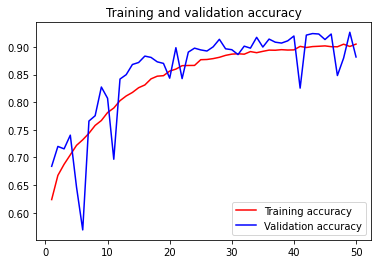

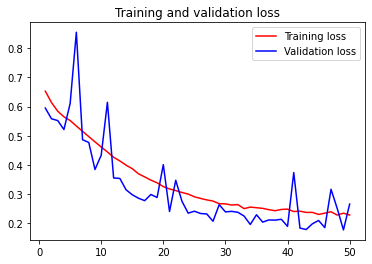

In [16]:
# plot accuracy and loss

import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

# accuracy

plt.plot(epochs, acc, "r", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.show()

# loss

plt.plot(epochs, loss, "r", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [18]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

In [19]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [20]:
model.save("convnet_dog_cat_with_augmentation_model.h5")
model_file = drive.CreateFile({"title" : "convnet_dog_cat_with_augmentation_model.h5"})
model_file.SetContentFile("convnet_dog_cat_with_augmentation_model.h5")
model_file.Upload()

In [ ]:
# download to google drive                      
drive.CreateFile({'id': model_file.get('id')})

In [36]:
# test the model with real image

import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150,150,3))
  
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=128)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving 184b8f2c10e30326f6ee92b3652408ac.jpg to 184b8f2c10e30326f6ee92b3652408ac.jpg
[0.]
184b8f2c10e30326f6ee92b3652408ac.jpg is a cat
